In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")
import datetime
from sklearn.model_selection import GridSearchCV, cross_val_score
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

### В нашем распоряжении  данные телеком компании: персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Необходимо научится прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

## План.
### 1. Провести предобработку и исследовательский анализ данных.
### 2. Провести обучение на логистической регресии, случайном лесе и CatBoost. выбрать лучшую по метрике ROC-AUC и обучить с оптимальнами параметрами. Дополнительно рассмотреть метрику accuracy.
### 3. Предоставить отчет о выполненной работе

# 1. Предобработка и исследовательский анализ данных.

In [2]:
try:
    df_contract = pd.read_csv(r'C:\Users\Галина\Desktop\final\contract.csv') # загрузим данные по контрактам с компа
except:  df_contract = pd.read_csv('/datasets/final_provider/contract.csv') # в тренажере

In [3]:
df_contract.head() # выведем 5 первых строк

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
# создадим столбец с целевым признаком остался клиент или ушел
df_contract['out'] = (df_contract['EndDate'] != 'No').astype(int)

In [5]:
# заменим значения No на дату выгрузки данных 
df_contract.EndDate.replace(['No'], ['2020-01-01'], inplace=True) 

In [6]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,out
0,7590-VHVEG,2020-01-01,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-01-01,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-01-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [7]:
df_contract.info() # посмотрим общую информацию о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
out                 7043 non-null int32
dtypes: float64(1), int32(1), object(7)
memory usage: 467.8+ KB


In [8]:
# переведем текстовые значения в числовые в столбце TotalCharges
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors ='coerce')

In [9]:
df_contract.isnull().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
out                  0
dtype: int64

In [10]:
 # проверим предположение , что пропуски возникли при контракте только начавшим действоать на дату выгрузки данных
df_contract[df_contract['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,out
488,4472-LVYGI,2020-02-01,2020-01-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,2020-02-01,2020-01-01,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,2020-02-01,2020-01-01,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,2020-02-01,2020-01-01,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,2020-02-01,2020-01-01,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,2020-02-01,2020-01-01,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,2020-02-01,2020-01-01,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,2020-02-01,2020-01-01,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,2020-02-01,2020-01-01,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,2020-02-01,2020-01-01,Two year,No,Mailed check,73.35,NaN,0


In [11]:
# в предыдущем шаге получили пропуски соответствующие дате контракта 2020-02-01 
# заменим на нулевые значения - платежи неразу не поступили
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(0)

In [12]:
# заменим текстовый формат на дату в столбце начало контракта BeginDate
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])

In [13]:
# заменим текстовый формат на дату в столбце начало контракта EndDate 
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])

In [14]:
# создадим столбец с пизнаком показывающим срок действия контракта в месяцах
df_contract['month'] = abs(df_contract['EndDate'].dt.month-df_contract['BeginDate'].dt.month) + (df_contract['EndDate'].dt.year-df_contract['BeginDate'].dt.year)*12

In [15]:
df_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,out,month
0,7590-VHVEG,2020-01-01,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,5575-GNVDE,2017-04-01,2020-01-01,One year,No,Mailed check,56.95,1889.50,0,39
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2
3,7795-CFOCW,2016-05-01,2020-01-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,52
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-01-01,One year,Yes,Mailed check,84.80,1990.50,0,25
7039,2234-XADUH,2014-02-01,2020-01-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,73
7040,4801-JZAZL,2019-03-01,2020-01-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,14
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,4


In [16]:
set(df_contract['PaymentMethod']) # посмотрим применяемые способы платежей

{'Bank transfer (automatic)',
 'Credit card (automatic)',
 'Electronic check',
 'Mailed check'}

In [17]:
#  посмотрим сведения о распределении значений в столбцах с данными о платяжах
df_contract.describe()

,MonthlyCharges,TotalCharges,out,month
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.265370,40.019026
std,30.090047,2266.794470,0.441561,25.602597
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,19.000000
50%,70.350000,1394.550000,0.000000,38.000000
75%,89.850000,3786.600000,1.000000,65.000000
max,118.750000,8684.800000,1.000000,83.000000


### по таблице contract  имеем данные по дате заключения контракта, дате закрытия контракта (если закрыт имеем дату, иначе нулевое значение), тип на год или по месячно, Способ платежа ( 4 вида), трата за месяц и за весь период контракта. Пропусков в данных нет.

In [18]:
# посмотрим размеры платежей в разрезе ушедших и действующих клиентов
x = 0 # индикаторное значение в столбце окончания контракта
out = df_contract.query('out != @x') # срез по ушедшим клиентам
out.describe()

,MonthlyCharges,TotalCharges,out,month
count,1869.000000,1869.000000,1869.0,1869.00000
mean,74.441332,1531.796094,1.0,21.71161
std,24.666053,1890.822994,0.0,20.08096
min,18.850000,18.850000,1.0,1.00000
25%,56.150000,134.500000,1.0,4.00000
50%,79.650000,703.550000,1.0,17.00000
75%,94.200000,2331.300000,1.0,33.00000
max,118.350000,8684.800000,1.0,83.00000


In [19]:
work = df_contract.query('out == @x') # срез по действующим  клиентам
work.describe()

,MonthlyCharges,TotalCharges,out,month
count,5174.000000,5174.000000,5174.0,5174.000000
mean,61.265124,2549.911442,0.0,46.632199
std,31.092648,2329.954215,0.0,24.122020
min,18.250000,0.000000,0.0,0.000000
25%,25.100000,572.900000,0.0,25.000000
50%,64.425000,1679.525000,0.0,48.000000
75%,88.400000,4262.850000,0.0,71.000000
max,118.750000,8672.450000,0.0,83.000000


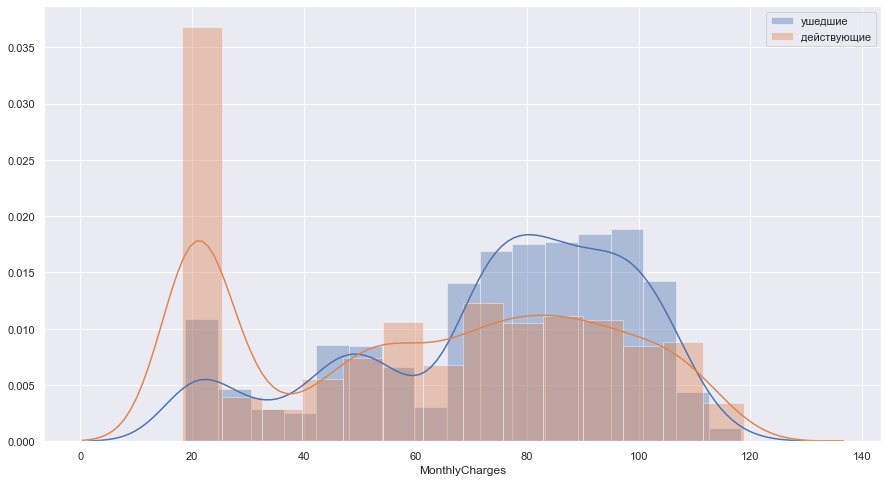

In [20]:
sns.set(rc={'figure.figsize':(15,8)})
sns.distplot(out['MonthlyCharges']) # построим график сумм месячных платяжей по групам ушедших и действующих договоров
sns.distplot(work['MonthlyCharges'])
plt.legend(('ушедшие', 'действующие'))

#### видно, что размер платежа в группе ушедших был выше, основная масса значений находится в промежутке от 70 до 110 , а среди действующих контрактов наиболшее количество приходится на 20 

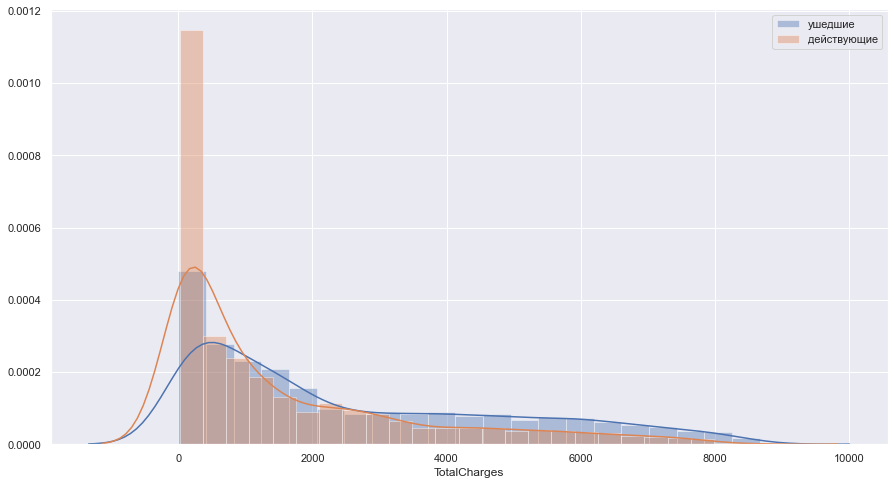

In [21]:
# построим график сумм всего уплаченых за время действия контракта по групам ушедших и действующих договоров
sns.distplot(work['TotalCharges'])
sns.distplot(out['TotalCharges']) 
plt.legend(('ушедшие', 'действующие'))

#### по графику суммы платежей за весь период контракта видим, что среди ушедших велика доля с малой суммой следовательно они продержались минимальное количество времени и сразу ушли. в долгосрочной перспективе наблюдается большая сумма платежей у  ушедших относительно действующих

In [22]:
# загрузим данные о пользователях интернет услугами
try:
    df_internet = pd.read_csv(r'C:\Users\Галина\Desktop\final\internet.csv')
except:
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [23]:
# добавим столбец показывающий наличие интернета
df_internet['internet'] = 'Yes'

In [24]:
# посмотрим 5 первых строк
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,Yes
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,Yes
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,Yes
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,Yes
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,Yes


In [25]:
# посмотрим общую информацию
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
internet            5517 non-null object
dtypes: object(9)
memory usage: 388.0+ KB


In [26]:
len(df_contract)-len(df_internet)

1526

#### значений меньше чем в предыдущей таблице, возможно не все клиенты пользуются интернет услугами. 1526 без интернета

In [27]:
# загрузим данные о клиентах
try:
    df_personalt = pd.read_csv(r'C:\Users\Галина\Desktop\final\personal.csv')
except:
    df_personalt = pd.read_csv('/datasets/final_provider/personal.csv')

In [28]:
# посмотрим 5 первых строк
df_personalt.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [29]:
# посмотрим общую информацию
df_personalt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [30]:
 # помотрим соотношение по гендорному типу среди клиентов
df_personalt.pivot_table(index=('gender'), values='customerID', aggfunc=('count'))

,customerID
gender,
Female,3488
Male,3555


In [31]:
# посмотрим количетсво пожилых клиентов
df_personalt['SeniorCitizen'].sum()

1142

#### получили персональные данные о 7043 клиентах из них 3555 мужчин и 3488 женьщин, а также среди них 1142 пожилых

In [32]:
# загрузим данные о наличии телефона
try:
    df_phone = pd.read_csv(r'C:\Users\Галина\Desktop\final\phone.csv')
except:
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [33]:
# добавим столбец показывающий наличие тулефона
df_phone['phone'] = 'Yes'

In [34]:
df_phone.head()

,customerID,MultipleLines,phone
0,5575-GNVDE,No,Yes
1,3668-QPYBK,No,Yes
2,9237-HQITU,No,Yes
3,9305-CDSKC,Yes,Yes
4,1452-KIOVK,Yes,Yes


In [35]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
phone            6361 non-null object
dtypes: object(3)
memory usage: 149.2+ KB


In [36]:
len(df_contract)-len(df_phone)

682

#### вновь в полученой таблице учтены не все клиенты, вероятно 682 не пользуются телефоном. 

In [37]:
# объеденим таблицы
dfs = [df_contract, df_internet, df_personalt, df_phone]
df_main = reduce(lambda left,right: pd.merge(left, right, how='outer'), dfs)


In [38]:
# посмотрим результата объединения
df_main.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,out,month,...,TechSupport,StreamingTV,StreamingMovies,internet,gender,SeniorCitizen,Partner,Dependents,MultipleLines,phone
0,7590-VHVEG,2020-01-01,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,...,No,No,No,Yes,Female,0,Yes,No,NaN,NaN
1,5575-GNVDE,2017-04-01,2020-01-01,One year,No,Mailed check,56.95,1889.50,0,39,...,No,No,No,Yes,Male,0,No,No,No,Yes
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,...,No,No,No,Yes,Male,0,No,No,No,Yes
3,7795-CFOCW,2016-05-01,2020-01-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,52,...,Yes,No,No,Yes,Male,0,No,No,NaN,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,...,No,No,No,Yes,Female,0,No,No,No,Yes


In [39]:
df_main.info() # выведем информацию от таблице

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
out                 7043 non-null int32
month               7043 non-null int64
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
internet            5517 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents       

In [40]:
df_main.isnull().sum() # посмотрим количество пропусков, т.к. в двух таблицах были данные не о всех клиентах

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
out                    0
month                  0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
internet            1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
phone                682
dtype: int64

###  Ожидаемо получили пропуски у клиентов не получающих услуги интернета или телефона, заменим их на индикаторные "No"

In [41]:
df_main = df_main.fillna('No')

In [42]:
df_main.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
out                 0
month               0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
internet            0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
phone               0
dtype: int64

In [43]:
df_main.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,out,month,...,TechSupport,StreamingTV,StreamingMovies,internet,gender,SeniorCitizen,Partner,Dependents,MultipleLines,phone
0,7590-VHVEG,2020-01-01,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,...,No,No,No,Yes,Female,0,Yes,No,No,No
1,5575-GNVDE,2017-04-01,2020-01-01,One year,No,Mailed check,56.95,1889.50,0,39,...,No,No,No,Yes,Male,0,No,No,No,Yes
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,...,No,No,No,Yes,Male,0,No,No,No,Yes
3,7795-CFOCW,2016-05-01,2020-01-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,52,...,Yes,No,No,Yes,Male,0,No,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,...,No,No,No,Yes,Female,0,No,No,No,Yes


In [44]:
# посмотрим соотношение количество ушедших от наличия телефона
out_main_phone = df_main.query('out != @x').pivot_table(index='phone', values='customerID', aggfunc='count')
out_main_phone

,customerID
phone,
No,170
Yes,1699


In [45]:
# посмотрим соотношение количество ушедших от наличия интрнета
out_main_internet = df_main.query('out != @x').pivot_table(index='internet', values='customerID', aggfunc='count')
out_main_internet

,customerID
internet,
No,113
Yes,1756


In [46]:
# посмотрим зависимость количество ушедших от гендерного признака
out_main_gender = df_main.query('out != @x').pivot_table(index='gender', values='customerID', aggfunc='count')
out_main_gender

,customerID
gender,
Female,939
Male,930


зависимости нет

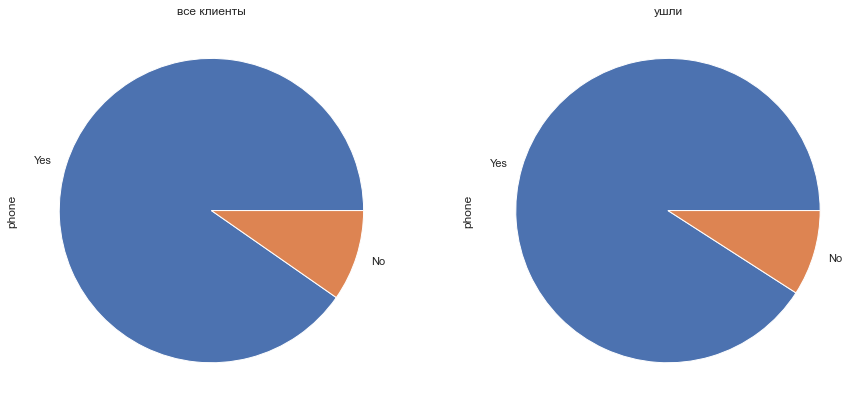

In [47]:
# построим диграмму соотношения объемов владельцев телефонов среди всех и ушедших клиентов
plt.subplot(1, 2, 1)
df_main['phone'].value_counts().plot(kind='pie', title='все клиенты')
plt.subplot(1, 2, 2)
out_main_phone = df_main[df_main['out'] == 1]['phone']
out_main_phone.value_counts().plot(kind='pie', ax=plt.gca(), title='ушли')
plt.show()

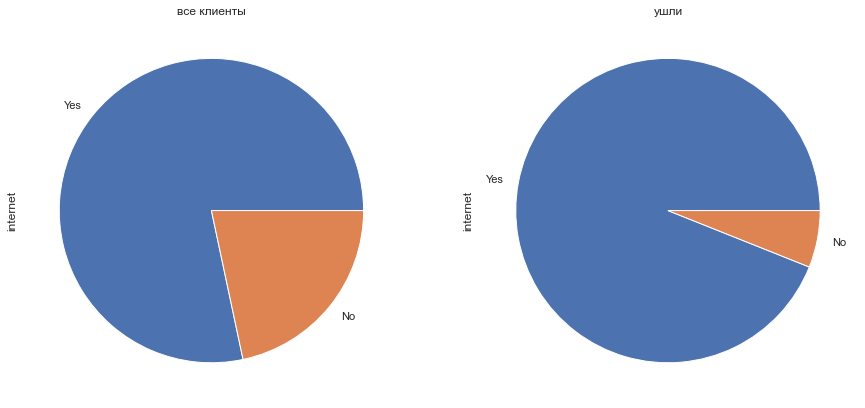

In [48]:
# построим диграмму соотношения объемов получателей интернет услуг среди всех и ушедших клиентов
plt.subplot(1, 2, 1)
df_main['internet'].value_counts().plot(kind='pie', title='все клиенты')
plt.subplot(1, 2, 2)
out_main_internet = df_main[df_main['out'] == 1]['internet']
out_main_internet.value_counts().plot(kind='pie', ax=plt.gca(), title='ушли')
plt.show()

# Вывод:
#### проведеный иследовательский анализ показал, что имеются данные по 7043 клиентам телеком компании с действующими (5174) и закрытыми контрактами (1869). Из них 682 не пользовались услугами телефонии и 1526 не пользовались интернет услугами. Среди клиентов 3555 мужчин и 3488 женьщин, а также среди них 1142 пожилых.  Количество ушедших не зависит от пола пользователя - примерно поровну. Наличие телефона или  интернета среди ушедших также вероютно не оказывает большого влияния на выбор клипента их количество 170 и 113 соответственно.

#### по графику месячных платяжей видно, что размер платежа в группе ушедших был выше, основная масса значений находится в промежутке от 70 до 110 , а среди действующих контрактов наиболшее количество приходится на 20
#### по графику суммы платежей за весь период контракта видим, что среди ушедших велика доля с малой суммой следовательно они продержались минимальное количество времени и сразу ушли. в долгосрочной перспективе наблюдается меньшая сумма платежей у ушедших относительно действующих
#### По графикам поведения клиентов в зависимости имели они услуги телефонии или интернета по сравнению между ушедшими и дествующими клиентами видно, что доля пользователей имевших телефон среди ушедших и оставшихся относительно всех клиентов практически рана, а по интерет-пользователям наблюдается заметно ольшая доля среди ушедших относительно оставшихся.

# 2. Обучение моделей

In [49]:
# создадим список категорийных признаков 
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 
                'OnlineBackup','DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies', 'internet', 'gender','Partner',
               'Dependents', 'MultipleLines', 'phone']

In [50]:
# переведем категорийные признаки в числовые значения
for i in cat_features:
    labelencoder = LabelEncoder()
    df_main[i] = labelencoder.fit_transform(df_main[i])

In [51]:
df_main.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,out,month,...,TechSupport,StreamingTV,StreamingMovies,internet,gender,SeniorCitizen,Partner,Dependents,MultipleLines,phone
0,7590-VHVEG,2020-01-01,2020-01-01,0,1,2,29.85,29.85,0,0,...,0,0,0,1,0,0,1,0,0,0
1,5575-GNVDE,2017-04-01,2020-01-01,1,0,3,56.95,1889.50,0,39,...,0,0,0,1,1,0,0,0,0,1
2,3668-QPYBK,2019-10-01,2019-12-01,0,1,3,53.85,108.15,1,2,...,0,0,0,1,1,0,0,0,0,1
3,7795-CFOCW,2016-05-01,2020-01-01,1,0,0,42.30,1840.75,0,52,...,1,0,0,1,1,0,0,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,0,1,2,70.70,151.65,1,2,...,0,0,0,1,0,0,0,0,0,1


In [52]:
df_main = df_main.drop('BeginDate', axis=1) # удалим даты начала и ухода и id
df_main = df_main.drop('EndDate', axis=1)
df_main = df_main.drop('customerID', axis=1)

In [53]:
target = df_main['out'] # разделим на цель и признаки
features = df_main.drop('out', axis=1)

In [54]:
# разделим на тестовую и полную тренировчную выборки, а затем на тренировочную и валидационую, оставим полную тренировочную 
# для работы с кроссвалидацией и обучения для проверки на тесте
features_test, features_ft, target_test, target_ft = train_test_split(    
    features, target, test_size=0.2, random_state=12345)

In [55]:
features_train, features_valid, target_train, target_valid = train_test_split(    
    features_ft, target_ft, test_size=0.2, random_state=12345)

In [56]:
# создадим функцию построения графика -ROC кривая
def graf(target, probabilities_one):
    fpr, tpr, thresholds = roc_curve(target, probabilities_one)
    plt.figure()
    plt.plot(fpr, tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

### Обучим для начала логистическую регрессию

In [57]:
%%time
model_LR = LogisticRegression()
model_LR.fit(features_train, target_train)
pred_valid_LR = model_LR.predict(features_valid)
accuracy_LR = accuracy_score(target_valid, pred_valid_LR)
print('accuracy для логистической регрессии', accuracy_LR)

accuracy для логистической регрессии 0.8333333333333334
Wall time: 15 ms


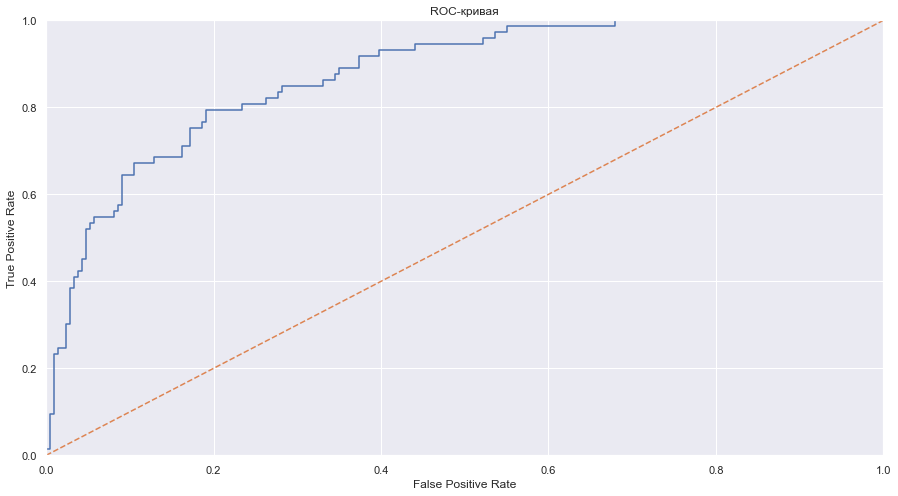

In [58]:
# Построим график -ROC кривая

probabilities_valid = model_LR.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

graf(target_valid, probabilities_one_valid)


In [59]:
# Вычислим значение метрикми AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc для логистической регрессии', auc_roc)

auc_roc для логистической регрессии 0.8729763387297633


In [60]:
# улучшим данные выровняв соотношение положительных и отричательных ответов в обучающей выборке
target_train.value_counts() # посмотрим соотношение 0 и 1 

0    821
1    306
Name: out, dtype: int64

разница составила около 3 - попробуем уравнять 


In [61]:
# создадим функцию увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)


In [62]:
target_upsampled.value_counts() # посмотрим соотношение 0 и 1 

1    918
0    821
Name: out, dtype: int64

In [63]:
%%time
model_LR = LogisticRegression()
model_LR.fit(features_upsampled, target_upsampled)
pred_valid_LR = model_LR.predict(features_valid)
accuracy_LR = accuracy_score(target_valid, pred_valid_LR)
accuracy_LR

Wall time: 18 ms


0.7163120567375887

несмотря на устранение дисбаланса значение  accuracy уменьшилось, не будем использовать это в работе

проверим результат на тесте обучив полной тренировочной 

In [64]:
model_LR = LogisticRegression()
model_LR.fit(features_ft, target_ft)
pred_test_LR = model_LR.predict(features_test)
accuracy_LR = accuracy_score(target_test, pred_test_LR)
print('accuracy для логистической регрессии на тесте', accuracy_LR)


accuracy для логистической регрессии на тесте 0.8285410010649628


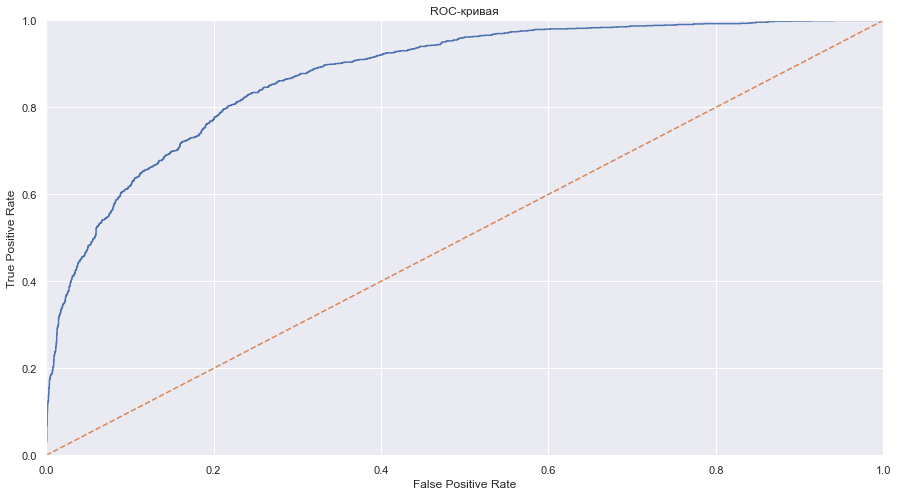

In [65]:
# Построим график -ROC кривая

probabilities_test = model_LR.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

graf(target_test, probabilities_one_test)

In [66]:
# Вычислим значение метрикми AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('auc_roc для логистической регрессии на тесте {:0.2f}'.format(auc_roc))

auc_roc для логистической регрессии на тесте 0.88


In [67]:
print('Полнота', recall_score(target_test, pred_test_LR))
print('Точность', precision_score(target_test, pred_test_LR))
print('F-1 мера', f1_score(target_test, pred_test_LR))

Полнота 0.5899328859060403
Точность 0.7123176661264181
F-1 мера 0.6453744493392072


### попробуем поработать со случайным лесом

In [68]:
%%time
model_rfc = RandomForestClassifier(random_state=1)
rfcparams = {'n_estimators' : range(10, 100, 10), 'max_depth' : range(1, 10, 2)}
rfc_grid = GridSearchCV(model_rfc, rfcparams,
cv=5, n_jobs=-1,
verbose=True)
rfc_grid.fit(features_ft, target_ft)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 222 out of 225 | elapsed:   17.6s remaining:    0.1s


Wall time: 18.3 s


[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   18.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max

In [69]:
rfc_grid.best_params_

{'max_depth': 9, 'n_estimators': 60}

In [70]:
rfc_grid.best_score_

0.8665720369056068

In [71]:
model_RFR = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=9)
model_RFR.fit(features_ft, target_ft)
pred_valid_RFR = model_RFR.predict(features_test)

In [72]:
# ознакомимся с оценкой важности функций в задаче класификации
importances_RFR = pd.DataFrame(model_RFR.feature_importances_, index =features_ft.columns, columns = ['importances'])
importances_RFR = importances_RFR.sort_values(by ='importances', ascending = False)
importances_RFR

,importances
month,0.300659
TotalCharges,0.158140
MonthlyCharges,0.137145
Type,0.115228
InternetService,0.042386
PaymentMethod,0.039413
OnlineSecurity,0.021386
PaperlessBilling,0.019845
TechSupport,0.018551
internet,0.017704


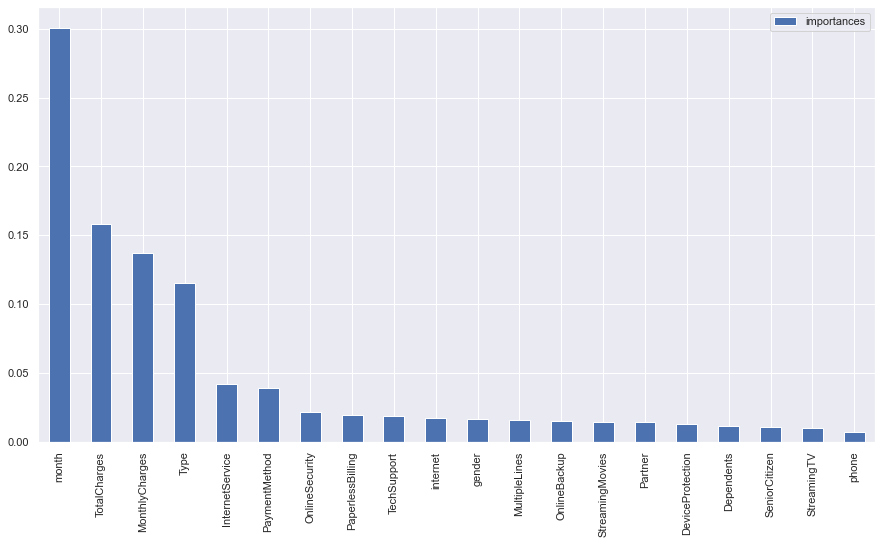

In [73]:
importances_RFR.plot(kind='bar')

### Наибольшую важность имеют срок контракта, размер платежей и тип

In [74]:
accuracy_RFR = accuracy_score(target_test, pred_valid_RFR)
print('accuracy для леса на тесте', accuracy_RFR)

accuracy для леса на тесте 0.8574724884629038


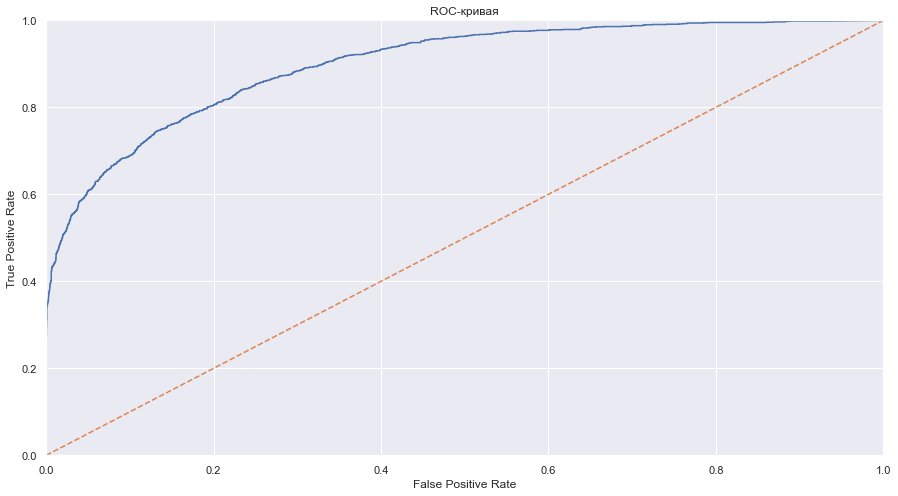

In [75]:
# Построим график -ROC кривая

probabilities_valid = model_RFR.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

graf(target_test, probabilities_one_valid)


In [76]:
# Вычислим значение метрикми AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('auc_roc для леса на тесте {:0.2f}'.format(auc_roc))

auc_roc для леса на тесте 0.90


In [77]:
print('Полнота', recall_score(target_test, pred_valid_RFR))
print('Точность', precision_score(target_test, pred_valid_RFR))
print('F-1 мера', f1_score(target_test, pred_valid_RFR))

Полнота 0.6395973154362417
Точность 0.7817883511074651
F-1 мера 0.7035806570690293


значение логистической регресии получились хуже: 0,88 против 0,90 на лесе для auc_roc и 0,85 против 0,86 для accuracy

### поработаем с CatBoost

In [78]:
%%time
model = CatBoostClassifier()
CBRparams = {'iterations' : range(20, 101, 10), 'depth' : range(1, 10, 2), 'learning_rate' : np.arange(0.1, 1, 0.5)}
rfc_grid = GridSearchCV(model, CBRparams, cv=3, n_jobs=-1, verbose=0)
rfc_grid.fit(features_ft, target_ft)

0:	learn: 0.6257602	total: 59.1ms	remaining: 5.26s
1:	learn: 0.5631565	total: 62.3ms	remaining: 2.74s
2:	learn: 0.5011632	total: 65.3ms	remaining: 1.9s
3:	learn: 0.4735874	total: 69.4ms	remaining: 1.49s
4:	learn: 0.4498296	total: 72.5ms	remaining: 1.23s
5:	learn: 0.4215000	total: 75.5ms	remaining: 1.06s
6:	learn: 0.4031453	total: 78.7ms	remaining: 934ms
7:	learn: 0.3873519	total: 82.1ms	remaining: 841ms
8:	learn: 0.3769906	total: 85.2ms	remaining: 767ms
9:	learn: 0.3656501	total: 88.4ms	remaining: 707ms
10:	learn: 0.3584498	total: 91.6ms	remaining: 658ms
11:	learn: 0.3458971	total: 94.9ms	remaining: 617ms
12:	learn: 0.3390409	total: 98.1ms	remaining: 581ms
13:	learn: 0.3331824	total: 101ms	remaining: 551ms
14:	learn: 0.3271734	total: 105ms	remaining: 527ms
15:	learn: 0.3238582	total: 109ms	remaining: 504ms
16:	learn: 0.3190289	total: 112ms	remaining: 482ms
17:	learn: 0.3144032	total: 115ms	remaining: 462ms
18:	learn: 0.3075545	total: 119ms	remaining: 443ms
19:	learn: 0.3012866	total: 1

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x000000C19395CD88>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': range(1, 10, 2),
                         'iterations': range(20, 101, 10),
                         'learning_rate': array([0.1, 0.6])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [79]:
rfc_grid.best_params_

{'depth': 5, 'iterations': 90, 'learning_rate': 0.1}

In [80]:
model = CatBoostClassifier(iterations=90 , depth=5, learning_rate=0.1)
model.fit(features_ft, target_ft, verbose=False)
pred_test = model.predict(features_test)

accuracy = accuracy_score(target_test, pred_test)
print('accuracy для CatBoost на тесте', accuracy)

accuracy для CatBoost на тесте 0.8750443734469293


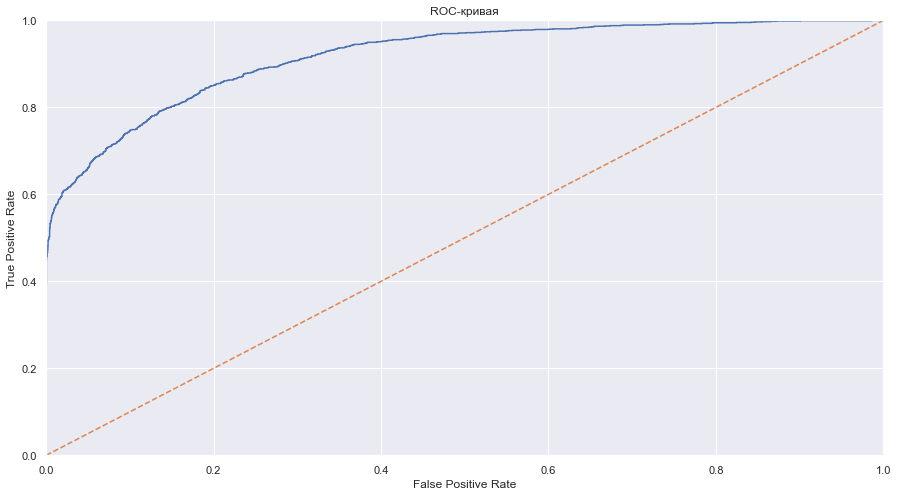

In [81]:
# Построим график -ROC кривая

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

graf(target_test, probabilities_one_test)

In [82]:
print('Полнота', recall_score(target_test, pred_test))
print('Точность', precision_score(target_test, pred_test))
print('F-1 мера', f1_score(target_test, pred_test))

Полнота 0.6476510067114094
Точность 0.8435314685314685
F-1 мера 0.7327258921791951


In [83]:
# Вычислим значение метрикми AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('auc_roc для CatBoost на тесте {:0.2f}'.format(auc_roc))

auc_roc для CatBoost на тесте 0.92


### Вывод: наилучший результат показал CatBoost (auc_roc = 0.92 и accuracy = 0.87)
Полнота 0.65
Точность 0.84
F-1 мера 0.73

## Отчет:
### В выполненой работе были выполнены все пункты плана, а имено: 1.проведение предобработки и исследовательского анализа данных; 2. Обученны модели, произведен подбор гиперпараметров, выбрана наилучшая модель.
### Трудностей при выполнени проекта не возникало
### Ключевым шагом в выполнении задачи стало создание признаков имеющих существленое влияние на качество модели - продолжительност контракта. Без этого признака значение контрольных метрик было низким. 
### Наилучший результат показал CatBoost (auc_roc = 0.92 и accuracy = 0.87)